# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM


# S250328ae

In [2]:
# Define events with start times and observation MJD times
events = {
    "S250328ae": {
        "chirp_mass": 11.96 + 9.0 - 5.84 ,
        "total_mass" : 28.93 + 22.4 - 14.23,
        "dL": 492.33,
        "start": '2025-03-28 00:00:00',
        "obs_mjd": [60763., 60764., 60771., 60790.],
        "pfs_obs_mjd": [60768.],
        "obs_depths": {
            "decam1": {"z": 21.4, "r": 22.7, "i": 22.1},
            "decam2": {"z": 21.9, "r": 22.8, "i": 22.5},
            "decam3": {"z": 21.0, "r": 21.3, "i": 21.2},
            "decam4": {"z": 21.6, "r": 22.3, "i": 22.1},
            "pfs1": {"blue": 21.3, "red": 21.3, "nir": 19.6}
        },
    }
}


In [3]:
event_total_mass = [events[key]["total_mass"] for key in events.keys()]
event_total_mass = np.array(event_total_mass)
event_total_mass

array([37.1])

Compute epochs wrt to event start date

In [4]:
# Compute epochs
all_epochs = {}
for event, data in events.items():
    start_time = Time(data["start"], format='iso')
    obs_times = Time(data["obs_mjd"], format='mjd')
    all_epochs[event] = (obs_times - start_time).to_value('day')

# Print results
epochs = []
for event, ep in all_epochs.items():
    epochs.append(ep)
    print(f"{event}: {ep}")

S250328ae: [ 1.  2.  9. 28.]


In [5]:
# obs depths
obs_depths = {}
for event, data in events.items():
    obs_depths[event] = data.get("obs_depths", {})
    print(f"{event}: {obs_depths[event]}")

S250328ae: {'decam1': {'z': 21.4, 'r': 22.7, 'i': 22.1}, 'decam2': {'z': 21.9, 'r': 22.8, 'i': 22.5}, 'decam3': {'z': 21.0, 'r': 21.3, 'i': 21.2}, 'decam4': {'z': 21.6, 'r': 22.3, 'i': 22.1}, 'pfs1': {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [6]:
epochs

[array([ 1.,  2.,  9., 28.])]

Model functions

In [7]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, aspect_ratio, height, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (aspect_ratio / 700) 
        * (M_SMBH / 10**8) 
        * (height / (aspect_ratio * 0.01))
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity+50) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [8]:
# Specific kick configurations

vk1 = 100 
vk2 = 200
vk3 = 300
vk4 = 400

# Density of the disk
density = 10**(-7)

# t_delay for emergence of EM signal
sig_start_times_1 = t_ram(event_total_mass, vk1)  # in days

sig_start_times_2 = t_ram(event_total_mass, vk2) #* 24  # in hours

sig_start_times_3 = t_ram(event_total_mass, vk3) #* 24  # in hours

sig_start_times_4 = t_ram(event_total_mass, vk4) #* 24  # in hours

# Diffusion time scale

# diffusion timescale for EM signal to emerge

mass_SMBH =  10**8 # depends on the mass of the SMBH
aspect_ratio = 700
height = aspect_ratio * 0.01 #np.random.uniform(0.001, 0.1, 1)
optical_depth = 100

diff_times = t_diff(mass_SMBH, aspect_ratio, height, optical_depth)
print('Diffusion timescale:', diff_times)

# peak times

peak_time_1 = 2 * sig_start_times_1
peak_time_2 = 2 * sig_start_times_2
peak_time_3 = 2 * sig_start_times_3
peak_time_4 = 2 * sig_start_times_4

# Peak luminosities
radiative_efficiency = 0.1

peak_luminosity_1 = L_BHL(event_total_mass, vk1, density, radiative_efficiency)
peak_luminosity_2 = L_BHL(event_total_mass, vk2, density, radiative_efficiency)
peak_luminosity_3 = L_BHL(event_total_mass, vk3, density, radiative_efficiency)
peak_luminosity_4 = L_BHL(event_total_mass, vk4, density, radiative_efficiency)
print('Peak luminosities:', peak_luminosity_1, peak_luminosity_2, peak_luminosity_3, peak_luminosity_4)

# End times

# end time for EM signal

theta = np.array([10, 60, 90]) # three different angles at which the BH could be kicked # we will take 60 degrees for plotting

end_times_1 = t_end(mass_SMBH, vk1, aspect_ratio, height, theta)
end_times_2 = t_end(mass_SMBH, vk2, aspect_ratio, height, theta)
end_times_3 = t_end(mass_SMBH, vk3, aspect_ratio, height, theta)
end_times_4 = t_end(mass_SMBH, vk4, aspect_ratio, height, theta)
print(end_times_1)
print(end_times_2)
print(end_times_3)
print(end_times_4)

Diffusion timescale: 8.0
Peak luminosities: [8.1565037e+47] [1.7618048e+47] [6.42057143e+46] [3.0209273e+46]
[807.73432041 159.24494417 134.33651477]
[403.86716021  79.62247209  67.16825738]
[269.24477347  53.08164806  44.77883826]
[201.9335801   39.81123604  33.58412869]


Lightcurves

In [9]:
# Define the light curve model
def gaussian_rise(rise_array, peak_lumi):
    t = rise_array 
    tg = rise_array[-1] - rise_array[0]
    t0 = rise_array[-1]
    return peak_lumi * np.exp(-((t - t0) ** 2) / (2 * tg ** 2))

def exponential_decay(fall_array, peak_lumi):
    t = fall_array 
    t0 = fall_array[0]
    te = fall_array[-1] - fall_array[0]
    return peak_lumi * np.exp(-(t - t0) / te)

def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis
    

Solar SED: Use solar magnitudes to obtain griz band mags

In [19]:
# Constants
L_sun = 3.828e33  # Solar luminosity in erg/s
M_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes

# Extract distance for each event
dLs = np.array([events[key]["dL"] for key in events.keys()])  

# Function to convert luminosity to absolute magnitude
def luminosity_to_mag(L, band):
    return M_sun[band] - 2.5 * np.log10(L / L_sun)

# Function to convert absolute magnitude to apparent magnitude
def absolute_to_apparent_mag(M_band, d_L):
    return M_band + 5 * np.log10(d_L) + 25

def luminosity_to_apparant_mag(L, d_L, band):
    M_band = luminosity_to_mag(L, band)
    return absolute_to_apparent_mag(M_band, d_L)


'''# Compute magnitudes for each band
mags = {}

for band in ["g", "r", "i", "z"]:
    # Compute absolute magnitudes per event
    M_band = luminosity_to_mag(L, band)
    
    # Compute apparent magnitudes per event
    mags[band] = absolute_to_apparent_mag(M_band, dLs)

#print("Apparent Magnitudes (griz bands):", mags)'''

'# Compute magnitudes for each band\nmags = {}\n\nfor band in ["g", "r", "i", "z"]:\n    # Compute absolute magnitudes per event\n    M_band = luminosity_to_mag(L, band)\n    \n    # Compute apparent magnitudes per event\n    mags[band] = absolute_to_apparent_mag(M_band, dLs)\n\n#print("Apparent Magnitudes (griz bands):", mags)'

Blackbody SED: Use blackbody approximation for SED

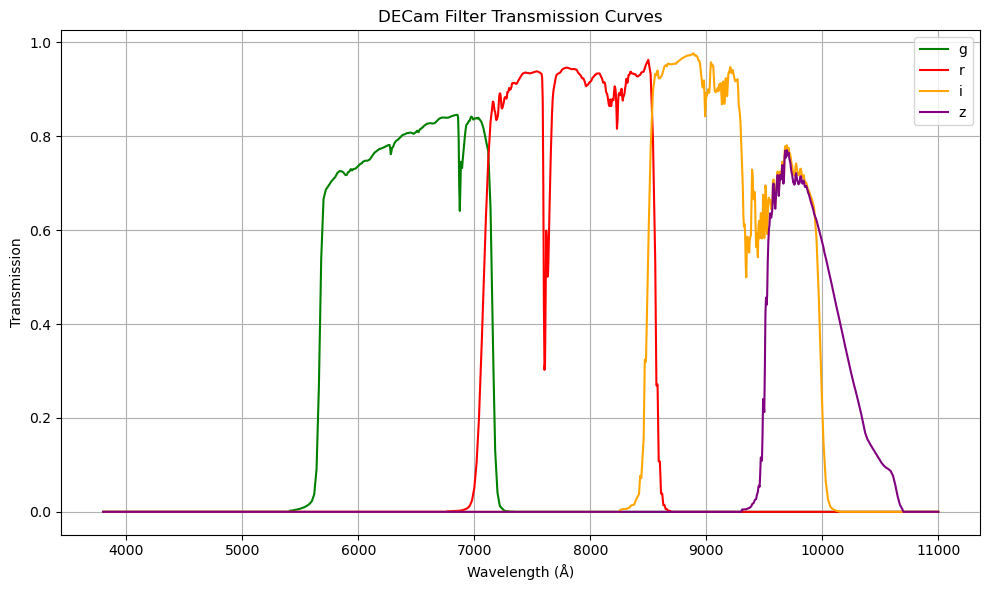

In [11]:
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)

wav = bandpasses[:,0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:,2]
filter_r = bandpasses[:,3]
filter_i = bandpasses[:,4]
filter_z = bandpasses[:,5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]

area = np.pi * (2 * u.m) ** 2

# Plot the transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='g', color='green')
plt.plot(wav, filter_r, label='r', color='red')
plt.plot(wav, filter_i, label='i', color='orange')
plt.plot(wav, filter_z, label='z', color='purple')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Transmission')
plt.title('DECam Filter Transmission Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
bp_g = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_g),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_r = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_r),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_i = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_i),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_z = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_z),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
filters = {'g': bp_g, 'r': bp_r, 'i': bp_i, 'z': bp_z}

In [13]:
wav_grid = np.linspace(3000, 11000, 2000) * u.AA  # DECam wavelength range

In [14]:
def effective_temperature(kick_velocity):
    return 10**5 * (kick_velocity / 100)**2

For a given kick velocity, we have a flare temperature.

The radius of the flare can be calculated by using the relationship between luminosity of the backbody and temperature.

The luminosity varies as the flare evolves for the given kick velocity.

In [15]:
def compute_bb_mags(luminosities, kick_velocity, luminosity_distance):
    temperature = effective_temperature(kick_velocity)
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm?
    radius = radius * u.cm.to(u.m) * u.m  # convert to meters
    #print(f'Radius: {radius}')
    redshift = z_at_value(cosmo.luminosity_distance, luminosity_distance)
    #print(f"Redshift for dL={luminosity_distance.to(u.Mpc):.2f} is z={redshift:.3f}")
    # ensure plain float
    redshift = float(redshift)
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2
    #print(f'Factors: {factors.shape}')
    results = []

    for F in factors:
        sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature) * F
        flux = sp_bb(wav_grid)  
        model = Empirical1D(points=wav_grid.value,     
                        lookup_table=flux.value)   
        sp_resampled = SourceSpectrum(model,
                                wave_unit=wav_grid.unit,   
                                flux_unit=flux.unit)
        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Kick velocity (km/s)': kick_velocity, 'T_eff (K)': temperature, **mags})

    df = pd.DataFrame(results)
    #print(df)

    return df

In [16]:
def compute_bb_mags_fast(luminosities, kick_velocity, luminosity_distance):
    # Compute temperature and radius
    temperature = effective_temperature(kick_velocity)  # scalar
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm
    radius = radius * u.cm.to(u.m) * u.m
    redshift = float(z_at_value(cosmo.luminosity_distance, luminosity_distance))

    # scaling factors for apparent flux
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2

    # Evaluate blackbody flux once
    sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature)
    flux_bb = sp_bb(wav_grid)  # PHOTLAM

    # Vectorized flux scaling
    flux_scaled = flux_bb.value[None, :] * factors[:, None]  # shape: (N_events, N_wavelengths)
    N_events = flux_scaled.shape[0]

    results = []

    for i in range(N_events):
        # Wrap into SourceSpectrum for synphot once per event
        sp_resampled = SourceSpectrum(
            Empirical1D(points=wav_grid.value, lookup_table=flux_scaled[i]),
            wave_unit=wav_grid.unit,
            flux_unit=flux_bb.unit
        )

        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Luminosities': luminosities[i], 'Kick velocity (km/s)': kick_velocity,
                        'T_eff (K)': temperature, **mags})

    return pd.DataFrame(results)

# Lightcurves

With customizations specifically for PFS-DESGW paper

In [17]:
# pfs epochs
pfs_epochs = {}
for event, data in events.items():
    if "pfs_obs_mjd" in data:  # check key exists
        start_time = Time(data["start"], format='iso')
        pfs_obs_times = Time(data["pfs_obs_mjd"], format='mjd')
        pfs_epochs[event] = (pfs_obs_times - start_time).to_value('day')

# Print results
pfs_epochs_list = []
for event, ep in pfs_epochs.items():
    pfs_epochs_list.append(ep)
    print(f"{event}: {ep}")

pfs_epochs_list , pfs_epochs

S250328ae: [6.]


([array([6.])], {'S250328ae': array([6.])})

In [18]:
values_decam = [
    {"z": 21.4, "r": 22.7, "i": 22.1},
    {"z": 21.9, "r": 22.8, "i": 22.5},
    {"z": 21.0, "r": 21.3, "i": 21.2},
    {"z": 21.6, "r": 22.3, "i": 22.1},
]
values_pfs = [
    {"blue": 21.3, "red": 21.3, "nir": 19.6}
]
obs_depths_decam = dict(zip(epochs[-1], values_decam))
obs_depths_pfs = dict(zip(pfs_epochs_list[-1], values_pfs))
print("DECam Depths:", obs_depths_decam)
print("PFS Depths:", obs_depths_pfs)

DECam Depths: {1.0: {'z': 21.4, 'r': 22.7, 'i': 22.1}, 2.0: {'z': 21.9, 'r': 22.8, 'i': 22.5}, 9.0: {'z': 21.0, 'r': 21.3, 'i': 21.2}, 28.0: {'z': 21.6, 'r': 22.3, 'i': 22.1}}
PFS Depths: {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


PLot lightcurves

DECam epochs: [ 1.  2.  9. 28.]
PFS epochs: [array([6.])]


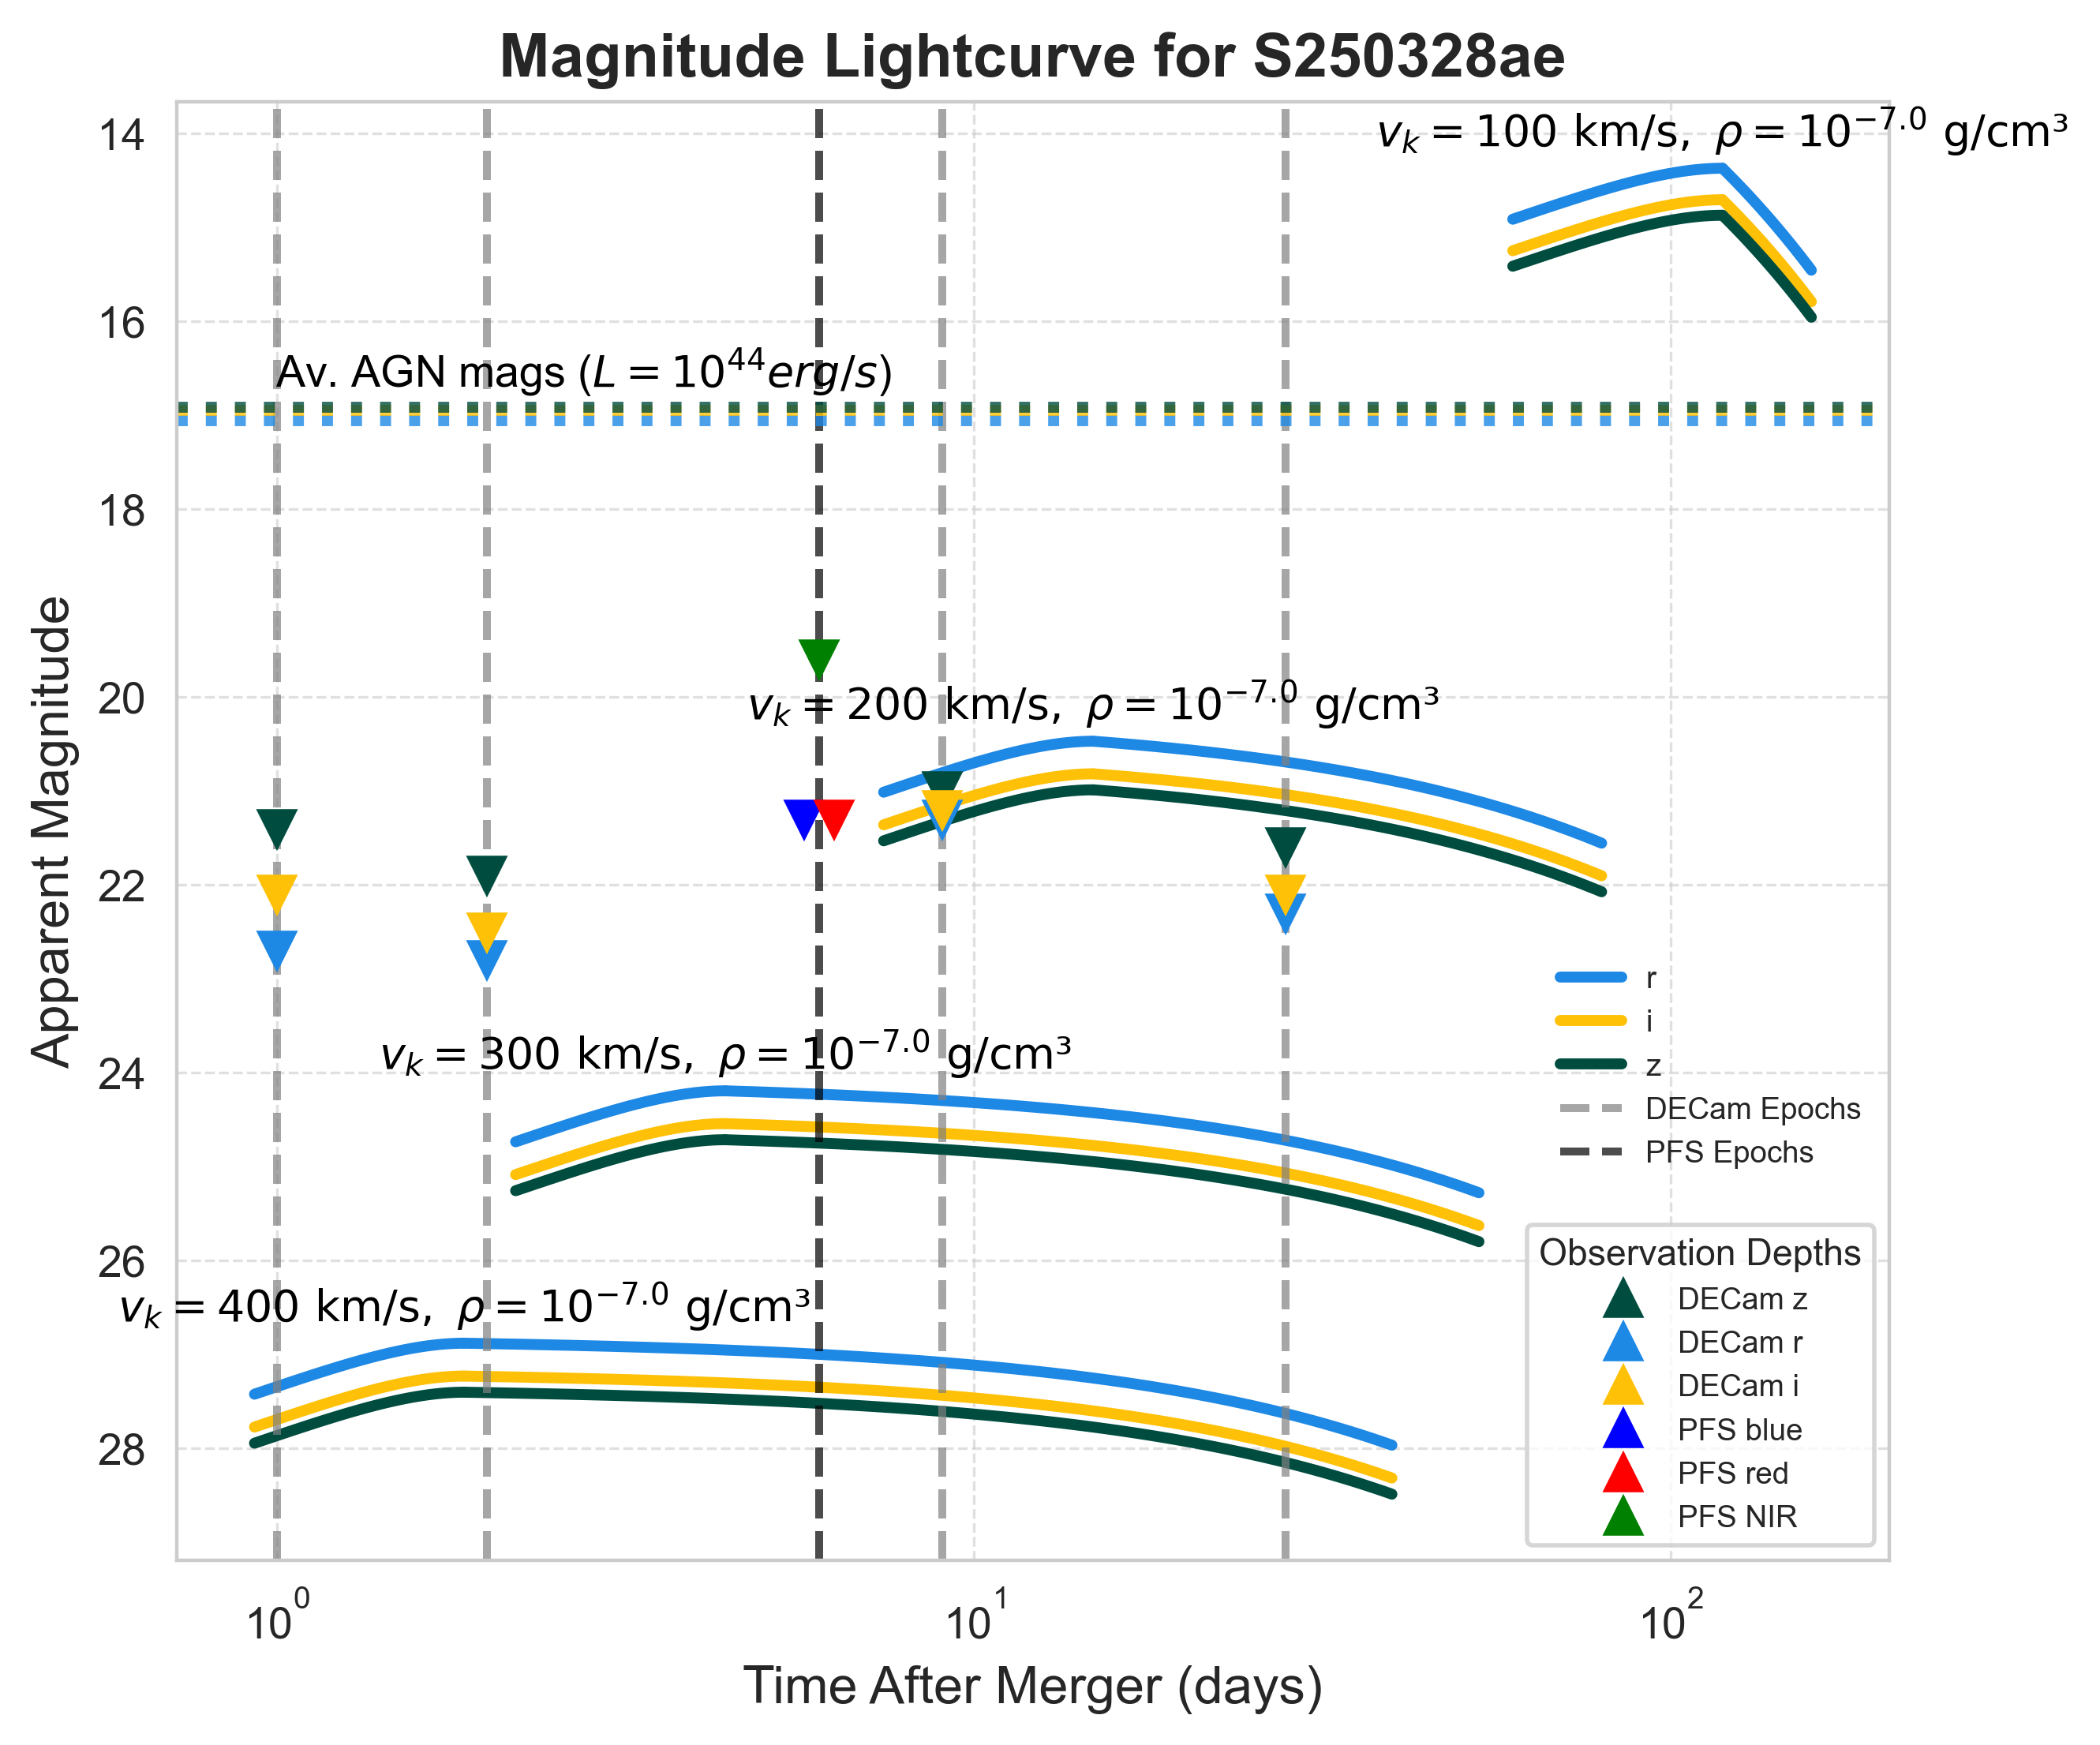

CPU times: user 53.2 s, sys: 839 ms, total: 54 s
Wall time: 53.7 s


In [40]:
%%time
sns.set_style("whitegrid")  

# Create a PDF file to save the plots
pdf = PdfPages(f"{list(events.keys())[0]}_plots.pdf")

for i, event in enumerate(events.keys()):
        
    fig, ax = plt.subplots(figsize=(7, 6), dpi=400)  # 1 row, 2 columns

    times_1 = np.array([sig_start_times_1[i], peak_time_1[i], end_times_1[1]])
    times_2 = np.array([sig_start_times_2[i], peak_time_2[i], end_times_2[1]])
    times_3 = np.array([sig_start_times_3[i], peak_time_3[i], end_times_3[1]])
    times_4 = np.array([sig_start_times_4[i], peak_time_4[i], end_times_4[1]])

    t_rise_1, t_fall_1, lumi_rise_1, lumi_fall_1 = light_curve_model(times_1, peak_luminosity_1[i])
    t_rise_2, t_fall_2, lumi_rise_2, lumi_fall_2 = light_curve_model(times_2, peak_luminosity_2[i])
    t_rise_3, t_fall_3, lumi_rise_3, lumi_fall_3 = light_curve_model(times_3, peak_luminosity_3[i])
    t_rise_4, t_fall_4, lumi_rise_4, lumi_fall_4 = light_curve_model(times_4, peak_luminosity_4[i])

    #print(t_rise_1.shape, t_fall_1.shape, lumi_rise_1.shape, lumi_fall_1.shape)

    # Blackbody SED for flare mags
    mag_rise_1_g = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_fall_1_g = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_rise_1_r = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_fall_1_r = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_rise_1_i = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_fall_1_i = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_rise_1_z = compute_bb_mags_fast(lumi_rise_1, vk1, dLs[i] * u.Mpc)['z'].to_numpy()
    mag_fall_1_z = compute_bb_mags_fast(lumi_fall_1, vk1, dLs[i] * u.Mpc)['z'].to_numpy()

    mag_rise_2_g = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_fall_2_g = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_rise_2_r = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_fall_2_r = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_rise_2_i = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_fall_2_i = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_rise_2_z = compute_bb_mags_fast(lumi_rise_2, vk2, dLs[i] * u.Mpc)['z'].to_numpy()
    mag_fall_2_z = compute_bb_mags_fast(lumi_fall_2, vk2, dLs[i] * u.Mpc)['z'].to_numpy()

    mag_rise_3_g = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_fall_3_g = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_rise_3_r = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_fall_3_r = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_rise_3_i = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_fall_3_i = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_rise_3_z = compute_bb_mags_fast(lumi_rise_3, vk3, dLs[i] * u.Mpc)['z'].to_numpy()
    mag_fall_3_z = compute_bb_mags_fast(lumi_fall_3, vk3, dLs[i] * u.Mpc)['z'].to_numpy()

    mag_rise_4_g = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_fall_4_g = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['g'].to_numpy()
    mag_rise_4_r = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_fall_4_r = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['r'].to_numpy()
    mag_rise_4_i = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_fall_4_i = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['i'].to_numpy()
    mag_rise_4_z = compute_bb_mags_fast(lumi_rise_4, vk4, dLs[i] * u.Mpc)['z'].to_numpy()
    mag_fall_4_z = compute_bb_mags_fast(lumi_fall_4, vk4, dLs[i] * u.Mpc)['z'].to_numpy()
    
    # Sun - like SED 
    '''mag_rise_strong_g = luminosity_to_apparant_mag(lumi_rise_strong, dLs[i], 'g')
    mag_fall_strong_g = luminosity_to_apparant_mag(lumi_fall_strong, dLs[i], 'g')
    mag_rise_strong_r = luminosity_to_apparant_mag(lumi_rise_strong, dLs[i], 'r')
    mag_fall_strong_r = luminosity_to_apparant_mag(lumi_fall_strong, dLs[i], 'r')
    mag_rise_strong_i = luminosity_to_apparant_mag(lumi_rise_strong, dLs[i], 'i')
    mag_fall_strong_i = luminosity_to_apparant_mag(lumi_fall_strong, dLs[i], 'i')
    mag_rise_strong_z = luminosity_to_apparant_mag(lumi_rise_strong, dLs[i], 'z')
    mag_fall_strong_z = luminosity_to_apparant_mag(lumi_fall_strong, dLs[i], 'z')

    mag_rise_weak_g = luminosity_to_apparant_mag(lumi_rise_weak, dLs[i], 'g')
    mag_fall_weak_g = luminosity_to_apparant_mag(lumi_fall_weak, dLs[i], 'g')
    mag_rise_weak_r = luminosity_to_apparant_mag(lumi_rise_weak, dLs[i], 'r')
    mag_fall_weak_r = luminosity_to_apparant_mag(lumi_fall_weak, dLs[i], 'r')
    mag_rise_weak_i = luminosity_to_apparant_mag(lumi_rise_weak, dLs[i], 'i')
    mag_fall_weak_i = luminosity_to_apparant_mag(lumi_fall_weak, dLs[i], 'i')
    mag_rise_weak_z = luminosity_to_apparant_mag(lumi_rise_weak, dLs[i], 'z')
    mag_fall_weak_z = luminosity_to_apparant_mag(lumi_fall_weak, dLs[i], 'z')

    mag_rise_intermediate_g = luminosity_to_apparant_mag(lumi_rise_intermediate, dLs[i], 'g')
    mag_fall_intermediate_g = luminosity_to_apparant_mag(lumi_fall_intermediate, dLs[i], 'g')
    mag_rise_intermediate_r = luminosity_to_apparant_mag(lumi_rise_intermediate, dLs[i], 'r')
    mag_fall_intermediate_r = luminosity_to_apparant_mag(lumi_fall_intermediate, dLs[i], 'r')
    mag_rise_intermediate_i = luminosity_to_apparant_mag(lumi_rise_intermediate, dLs[i], 'i')
    mag_fall_intermediate_i = luminosity_to_apparant_mag(lumi_fall_intermediate, dLs[i], 'i')
    mag_rise_intermediate_z = luminosity_to_apparant_mag(lumi_rise_intermediate, dLs[i], 'z')
    mag_fall_intermediate_z = luminosity_to_apparant_mag(lumi_fall_intermediate, dLs[i], 'z')'''

    #ax2.plot(t_rise_1, mag_rise_strong_g, color='#D81B60', linewidth=2.5)
    #ax2.plot(t_fall_1, mag_fall_strong_g, color='#D81B60', linewidth=2.5)
    ax.plot(t_rise_1, mag_rise_1_r, color='#1E88E5', linewidth=2.5)#, linestyle=':', label='Strong Kick')
    ax.plot(t_fall_1, mag_fall_1_r, color='#1E88E5', linewidth=2.5)#, linestyle=':')
    ax.plot(t_rise_1, mag_rise_1_i, color='#FFC107', linewidth=2.5)#, linestyle=':')
    ax.plot(t_fall_1, mag_fall_1_i, color='#FFC107', linewidth=2.5)#, linestyle=':')
    ax.plot(t_rise_1, mag_rise_1_z, color='#004D40', linewidth=2.5)#, linestyle=':')
    ax.plot(t_fall_1, mag_fall_1_z, color='#004D40', linewidth=2.5)#, linestyle=':')

    ax.annotate(rf"$v_k = {vk1}\ \text{{km/s}},\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
            xy=(t_rise_1[-1], mag_rise_1_r[-1]),  
            textcoords="offset points", 
            xytext=(0, 5),  
            ha='center', 
            fontsize='medium', 
            color='black')
    
    #ax2.plot(t_rise_2, mag_rise_intermediate_g, color='#D81B60', linewidth=2.5)
    #ax2.plot(t_fall_2, mag_fall_intermediate_g, color='#D81B60', linewidth=2.5)
    ax.plot(t_rise_2, mag_rise_2_r, color='#1E88E5', linewidth=2.5)#, linestyle='--', label='Intermediate Kick')
    ax.plot(t_fall_2, mag_fall_2_r, color='#1E88E5', linewidth=2.5)#, linestyle='--')
    ax.plot(t_rise_2, mag_rise_2_i, color='#FFC107', linewidth=2.5)#, linestyle='--')
    ax.plot(t_fall_2, mag_fall_2_i, color='#FFC107', linewidth=2.5)#, linestyle='--')
    ax.plot(t_rise_2, mag_rise_2_z, color='#004D40', linewidth=2.5)#, linestyle='--')
    ax.plot(t_fall_2, mag_fall_2_z, color='#004D40', linewidth=2.5)#, linestyle='--')

    ax.annotate(rf"$v_k = {vk2}\ \text{{km/s}},\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
            xy=(t_rise_2[-1], mag_rise_2_r[-1]),  
            textcoords="offset points", 
            xytext=(0, 5), 
            ha='center', 
            fontsize='medium', 
            color='black')
    
    #ax2.plot(t_rise_3, mag_rise_weak_g, color='#D81B60', linewidth=2.5, label="g")
    #ax2.plot(t_fall_3, mag_fall_weak_g, color='#D81B60', linewidth=2.5)
    ax.plot(t_rise_3, mag_rise_3_r, color='#1E88E5', linewidth=2.5)#, linestyle='-.', label="Weak Kick")
    ax.plot(t_fall_3, mag_fall_3_r, color='#1E88E5', linewidth=2.5)
    ax.plot(t_rise_3, mag_rise_3_i, color='#FFC107', linewidth=2.5)#, linestyle='-.')
    ax.plot(t_fall_3, mag_fall_3_i, color='#FFC107', linewidth=2.5)
    ax.plot(t_rise_3, mag_rise_3_z, color='#004D40', linewidth=2.5)#, linestyle='-.')
    ax.plot(t_fall_3, mag_fall_3_z, color='#004D40', linewidth=2.5)

    ax.annotate(rf"$v_k = {vk3}\ \text{{km/s}},\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
            xy=(t_rise_3[-1], mag_rise_3_r[-1]),  
            textcoords="offset points", 
            xytext=(0, 5),  
            ha='center', 
            fontsize='medium', 
            color='black')

    ax.plot(t_rise_4, mag_rise_4_r, color='#1E88E5', linewidth=2.5, label="r")
    ax.plot(t_fall_4, mag_fall_4_r, color='#1E88E5', linewidth=2.5)
    ax.plot(t_rise_4, mag_rise_4_i, color='#FFC107', linewidth=2.5, label="i")
    ax.plot(t_fall_4, mag_fall_4_i, color='#FFC107', linewidth=2.5)
    ax.plot(t_rise_4, mag_rise_4_z, color='#004D40', linewidth=2.5, label="z")
    ax.plot(t_fall_4, mag_fall_4_z, color='#004D40', linewidth=2.5)

    ax.annotate(rf"$v_k = {vk4}\ \text{{km/s}},\ \rho = 10^{{{np.log10(density):.1f}}}\ \text{{g/cm³}}$", 
            xy=(t_rise_4[-1], mag_rise_4_r[-1]),  
            textcoords="offset points", 
            xytext=(0, 5),  
            ha='center', 
            fontsize='medium', 
            color='black')
    
    colors = {'g': '#D81B60', 'r': '#1E88E5', 'i': '#FFC107', 'z': '#004D40'}
    for x in epochs[i]:
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=1.8, alpha=0.7, label='DECam Epochs' if x == epochs[i][0] else "")
    
    for x in pfs_epochs_list:
        ax.axvline(x=x, color='black', linestyle='--', linewidth=1.8, alpha=0.7, label='PFS Epochs' if x == pfs_epochs_list[0] else "")
    #ax2.axvline(x=0, color='black', linestyle='-', linewidth=2.5, alpha=0.8, label='Merger Time (t=0)')

    # Average luminosity line
    

    avg_lumi = 10**44
    mags_agn = {}  # Sun like SED is ok for the AGN itself
    for band in ["g", "r", "i", "z"]:
        M_band = luminosity_to_mag(avg_lumi, band)
        m_band = absolute_to_apparent_mag(M_band, dLs[i])
        mags_agn[band] = m_band
    
    for band in ['r', 'i', 'z']: #['g', 'r', 'i', 'z']:
        ax.axhline(y=mags_agn[band], color=colors[band], linestyle=':', linewidth=2.5, alpha=0.8)#, label=f"Average AGN Luminosity: {band}")

    ax.annotate('Av. AGN mags ($L=10^{44} erg/s$)', 
            xy=(50, mags_agn['z']),  
            textcoords="offset points", 
            xytext=(-200, 5),  
            ha='center', 
            fontsize='medium', 
            color='black')
    
    

    ax.set_xlabel("Time After Merger (days)", fontsize=12)
    ax.set_ylabel("Apparent Magnitude", fontsize=12)
    ax.set_title(f"Magnitude Lightcurve for {event}", fontsize=14, fontweight='bold')
    #ax2.legend(frameon=False)#loc='lower right')
    #main_legend = ax.legend( frameon=False, fontsize='small', bbox_to_anchor=(0.34, 0.8))
    main_legend = ax.legend(
        frameon=False,
        fontsize='x-small',
        bbox_to_anchor=(1.00, 0.25),   # same x, higher y
        loc='lower right'              # align lower-right corners
    )
    ax.add_artist(main_legend)  # Add this explicitly so the second legend can be added too

    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
    ax.invert_yaxis() 
    #ax2.set_xlim(-1, 60)
    #ax2.set_xlim(0.1, 100)  # Set x-axis limits for better visibility
    ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_ylim(45, 42)

    # Custom tick formatter: Display original (non-log) values
    #ax2.xaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:.0f}"))

    # Add major and minor ticks for better readability
    #ax2.xaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=10))
    #ax2.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

    # Observation depths
    for x in epochs[i]:
        #print(x)
        ax.plot(x, obs_depths_decam[x]['z'], color=colors['z'], marker='v', markersize=8, label='DECam Observation Depths' if x == epochs[i][0] else "")
        ax.plot(x, obs_depths_decam[x]['r'], color=colors['r'], marker='v', markersize=8)
        ax.plot(x, obs_depths_decam[x]['i'], color=colors['i'], marker='v', markersize=8)
    print("DECam epochs:", epochs[i])
    print("PFS epochs:", pfs_epochs_list)
    for x in pfs_epochs_list:
        offset = 0.3
        mjd_epoch = float(x[0])  # extract the scalar from array([6.])
        ax.plot(mjd_epoch - offset, obs_depths_pfs[mjd_epoch]['blue'], color='blue', marker='v', markersize=8, label='PFS Blue-band Depth')
        ax.plot(mjd_epoch + offset, obs_depths_pfs[mjd_epoch]['red'], color='red', marker='v', markersize=8, label='PFS Red-band Depth')
        ax.plot(mjd_epoch, obs_depths_pfs[mjd_epoch]['nir'], color='green', marker='v', markersize=8, label='PFS NIR Depth')

    # --- Custom legend ---
    depth_legend_lines = [
        Line2D([0], [0], color=colors['z'], marker='^', linestyle='None', markersize=8, label='DECam z'),
        Line2D([0], [0], color=colors['r'], marker='^', linestyle='None', markersize=8, label='DECam r'),
        Line2D([0], [0], color=colors['i'], marker='^', linestyle='None', markersize=8, label='DECam i'),
        Line2D([0], [0], color='blue', marker='^', linestyle='None', markersize=8, label='PFS blue'),
        Line2D([0], [0], color='red', marker='^', linestyle='None', markersize=8, label='PFS red'),
        Line2D([0], [0], color='green', marker='^', linestyle='None', markersize=8, label='PFS NIR'),
    ]

    #depth_legend = ax.legend(handles=depth_legend_lines, loc='lower right', bbox_to_anchor=(0.26, 0.6), frameon=True, title="Observation Depths", fontsize='small', title_fontsize='small')
    depth_legend = ax.legend(
        handles=depth_legend_lines,
        loc='lower right',          # corner inside the axes
        bbox_to_anchor=(1, 0),      # anchor to the bottom-right of the axes
        frameon=True,
        title="Observation Depths",
        fontsize='x-small',
        title_fontsize='small'
    )

    pdf.savefig(fig)
    plt.show()
    
pdf.close()